In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import MT5ForConditionalGeneration, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from datasets import load_dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm 
from scipy.stats import kurtosis
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
from scipy.stats import gmean
from evaluate import load

import matplotlib.pyplot as plt 
import evaluate
import torch
import time
import nltk
import numpy as np
import torch.nn.functional as F

nltk.download('wordnet')
bertscore = load("bertscore")

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jinhyunpark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Define metrics

In [2]:
# jhpark: verified that this is a correct way to use this 
def calculate_rouge(true_sentence, predicted_sentence):
    # jhpark: rouge1/rouge2 (e.g. rouge1, rouge2): n-gram based scoring.
    # jhpark: rougeL: Longest common subsequence based scoring.
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, predicted_sentence)
    return scores

In [3]:
# jhpark: verified that this is a correct way to use this 
def calculate_bleu(true_tokens, predicted_tokens):
    '''
    * reference for smoothing: A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU, Boxing Chen and Collin Cherry (2014)
    * method1: Smoothing method 1: Add *epsilon* counts to precision with 0 counts.
    * https://www.nltk.org/_modules/nltk/translate/bleu_score.html for more details
    '''
    bleu_score = sentence_bleu(true_tokens, predicted_tokens, smoothing_function=SmoothingFunction().method1)
    return bleu_score

### Datasets

In [4]:
# english to X is only possible for T5
from datasets import load_dataset, load_from_disk

# ds_de_en = load_dataset("wmt/wmt14", "de-en")
# ds_fr_en = load_dataset("wmt/wmt15", "fr-en")
# ds_ro_en = load_dataset("wmt/wmt16", "ro-en")

# ds_de_en.save_to_disk("../wmt14_de_en")
# ds_fr_en.save_to_disk("../wmt15_fr_en")
# ds_ro_en.save_to_disk("../wmt16_ro_en")

ds_de_en = load_from_disk("../wmt14_de_en")
ds_fr_en = load_from_disk("../wmt15_fr_en")
ds_ro_en = load_from_disk("../wmt16_ro_en")

### Models

In [5]:
t5_tokenizer_small = AutoTokenizer.from_pretrained('t5-small')
t5_model_small = AutoModelForSeq2SeqLM.from_pretrained('t5-small')
print("Done with small")

t5_tokenizer_base = AutoTokenizer.from_pretrained('t5-base')
t5_model_base = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
print("Done with base")

Done with small
Done with base


### Init

In [6]:
def calculate_probs_from_logits(logits):
    return F.softmax(logits, dim=-1)

def generate_output_with_probs(model, tokenizer, example, top_k=5):
    '''
    - High Kurtosis: An indicator that the data has heavy tails or outliers.
    - Low Kurtosis:  An indicator that the data has thin tails and lacks outliers.
    '''
    inputs = tokenizer.encode(example, return_tensors="pt")
    output_ids = model.generate(inputs, max_new_tokens=np.inf, return_dict_in_generate=True, output_scores=True, return_legacy_cache=False)
    output_tokens = output_ids.sequences[0]
    output_probs = []
    output_kurtosis = []

    # Retrieve probabilities for each token
    for i, token_id in tqdm(enumerate(output_tokens)):
        if i == 0:  # Skip the initial token
            continue
        probs = calculate_probs_from_logits(output_ids.scores[i - 1])[0]
        token_prob = probs[token_id].item()  

        top_probs, _ = torch.topk(probs, 1000)
        kurt = kurtosis(top_probs)

        output_probs.append(token_prob)
        output_kurtosis.append(kurt)
        
    decoded_output = tokenizer.decode(output_tokens, skip_special_tokens=True)
    return decoded_output, np.array(output_probs), np.array(output_kurtosis)

### 1. Generate translations (English to German)

--------------- Sample 0 ---------------


11it [00:00, 1635.61it/s]


[Sentences]
   Input: translate English to German: Resumption of the session
   True Translation: Wiederaufnahme der Sitzungsperiode
   Predicted Translation: Wiederaufnahme der Sitzungsperiode

[Scores]
   BLEU score: 1.0
   METEOR score: 0.9993141289437586
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [1.0], 'recall': [1.0], 'f1': [1.0], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilities (Geometric mean): 0.998
   Top 1 token probabilities: [0.994 0.999 0.996 0.994 1.    0.999 1.    1.    1.    0.999]
   Scaled kurtosis: [0.865 0.988 0.783 0.    1.    0.993 0.997 0.996 0.996 0.991]


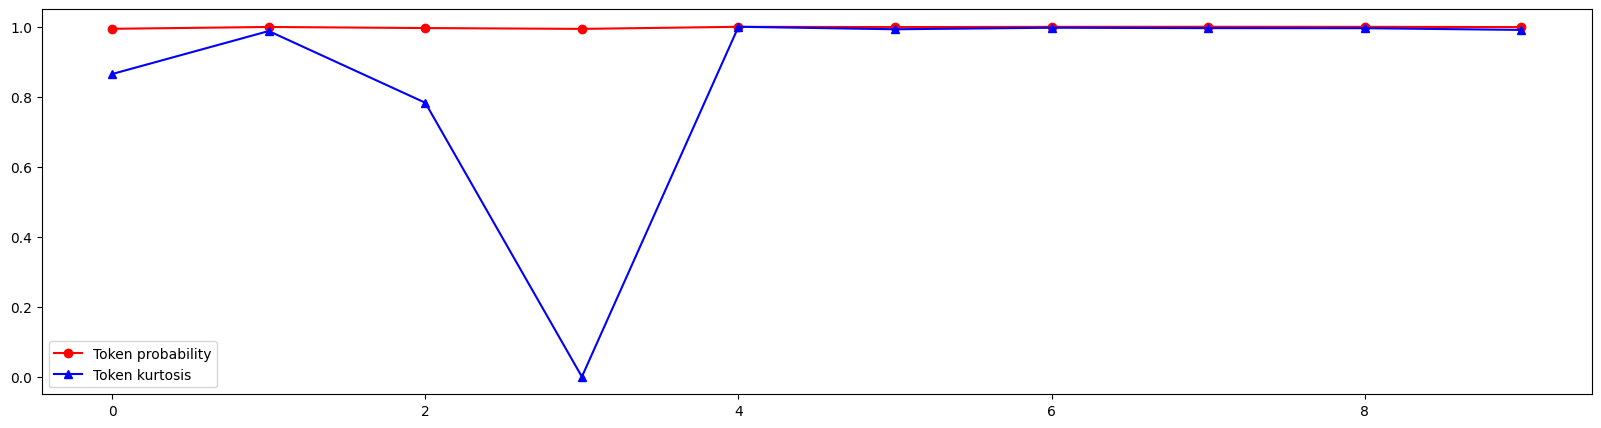

--------------- Sample 1 ---------------


62it [00:00, 1490.53it/s]


[Sentences]
   Input: translate English to German: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
   True Translation: Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
   Predicted Translation: Ich erkläre die am Freitag, dem 17. Dezember 1999 unterbrochene Sitzungsperiode des Europäischen Parlaments für wieder aufgenommen, und ich möchte Ihnen erneut ein glückliches neues Jahr wünschen, in der Hoffnung, dass Sie einen angenehmen Festtag genießen.

[Scores]
   BLEU score: 0.4955474787092686
   METEOR score: 0.6400087260034905
   ROUGE score: {'rouge1': Score(precision=0.4883720930232558, recall=0.6176470588235294, fmeasure=0.5454545454545455), 'rouge2': Score(p

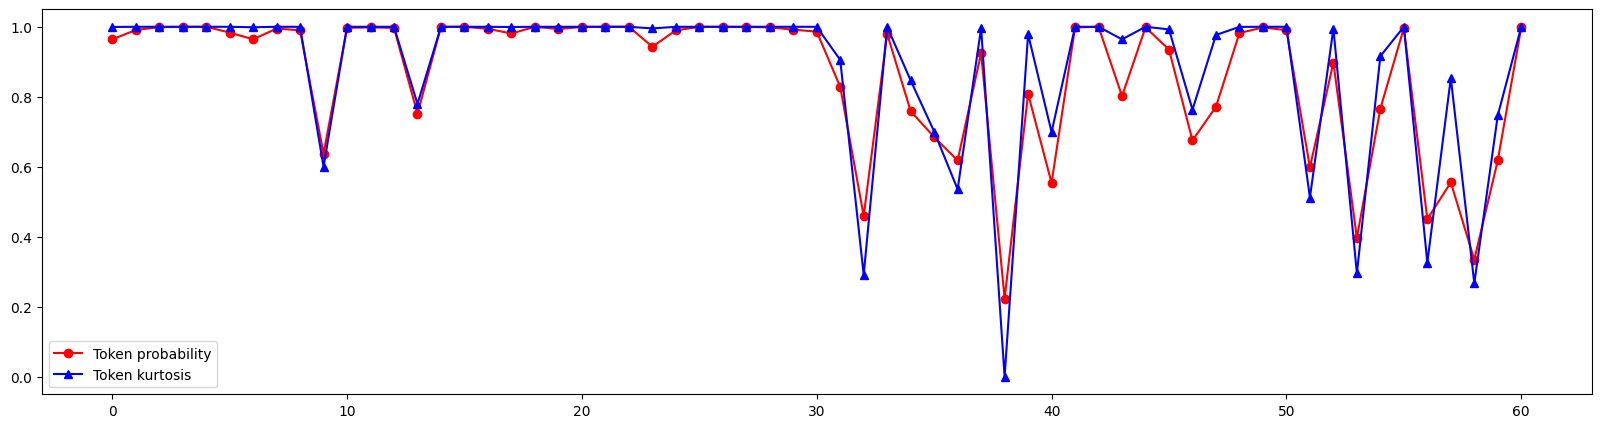

--------------- Sample 2 ---------------


65it [00:00, 1372.30it/s]

[Sentences]
   Input: translate English to German: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
   True Translation: Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.
   Predicted Translation: Obwohl, wie Sie gesehen haben, der gefürchtete "Millennium-Fehler" nicht zustande kam, erlitten die Menschen in einigen Ländern noch immer eine Reihe von Naturkatastrophen, die wirklich schrecklich waren.

[Scores]
   BLEU score: 0.258758268765002
   METEOR score: 0.5387931034482759
   ROUGE score: {'rouge1': Score(precision=0.26666666666666666, recall=0.3333333333333333, fmeasure=0.2962962962962963), 'rouge2': Score(precision=0.10344827586206896, recall=0.13043478260869565, fmeasure=0.11538461538461538), 'rougeL': Sco

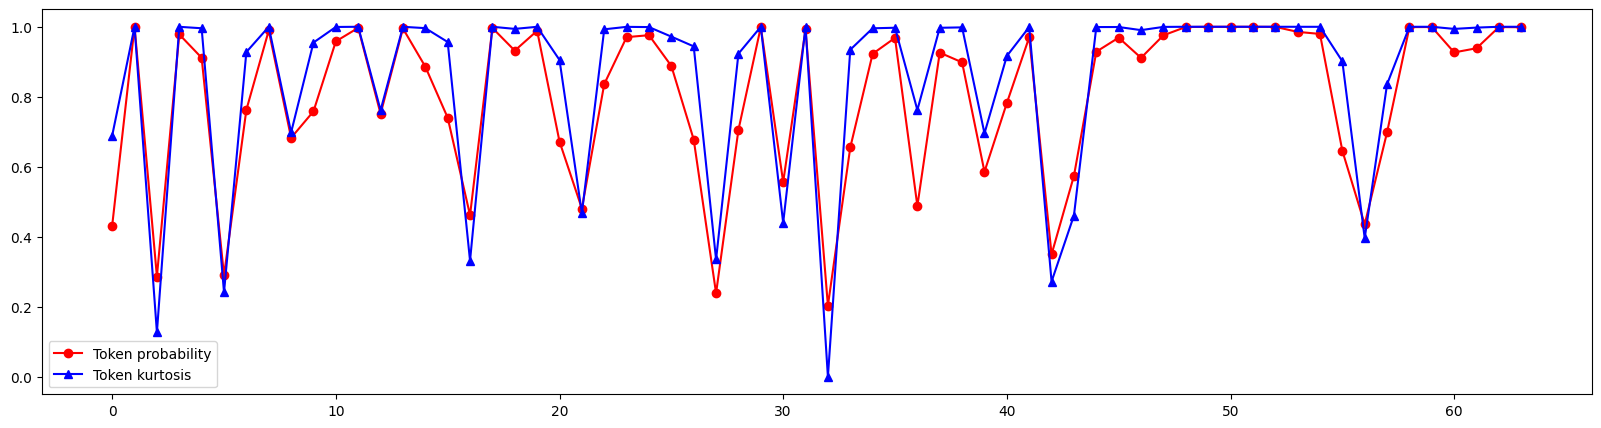

--------------- Sample 3 ---------------


28it [00:00, 1477.91it/s]

[Sentences]
   Input: translate English to German: You have requested a debate on this subject in the course of the next few days, during this part-session.
   True Translation: Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.
   Predicted Translation: Sie haben in den nächsten Tagen, während dieser Sitzung, eine Aussprache zu diesem Thema beantragt.

[Scores]
   BLEU score: 0.251696695878184
   METEOR score: 0.41573183760683763
   ROUGE score: {'rouge1': Score(precision=0.4117647058823529, recall=0.4117647058823529, fmeasure=0.4117647058823529), 'rouge2': Score(precision=0.25, recall=0.25, fmeasure=0.25), 'rougeL': Score(precision=0.29411764705882354, recall=0.29411764705882354, fmeasure=0.29411764705882354)}
   BERT score: {'precision': [0.8852511644363403], 'recall': [0.8957069516181946], 'f1': [0.8904483318328857], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty 

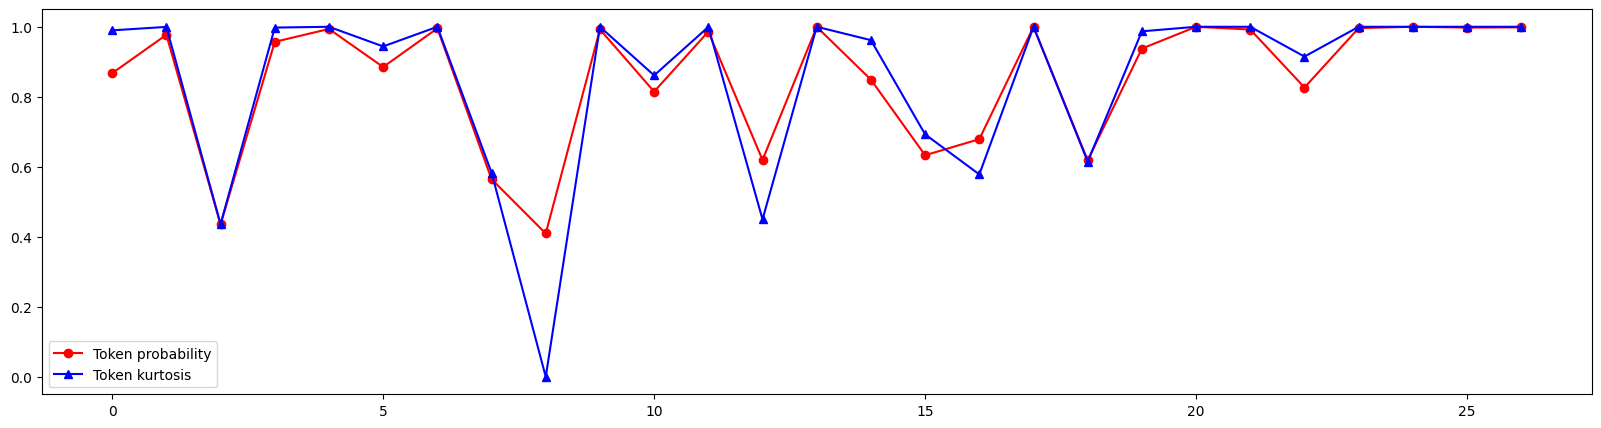

--------------- Sample 4 ---------------


58it [00:00, 958.37it/s]

[Sentences]
   Input: translate English to German: In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.
   True Translation: Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.
   Predicted Translation: In der Zwischenzeit möchte ich, wie einige Abgeordnete es gefordert haben, im Namen aller betroffenen Opfer, insbesondere der schrecklichen Stürme, in den verschiedenen Ländern der Europäischen Union eine Schweigeminute einlegen.

[Scores]
   BLEU score: 0.2910242261957368
   METEOR score: 0.5503142295750778
   ROUGE score: {'rouge1': Score(precision=0.5882352941176471, recall=0.5714285714285714, fmeasure=0.5797101449275363), 'rouge2': Score(preci

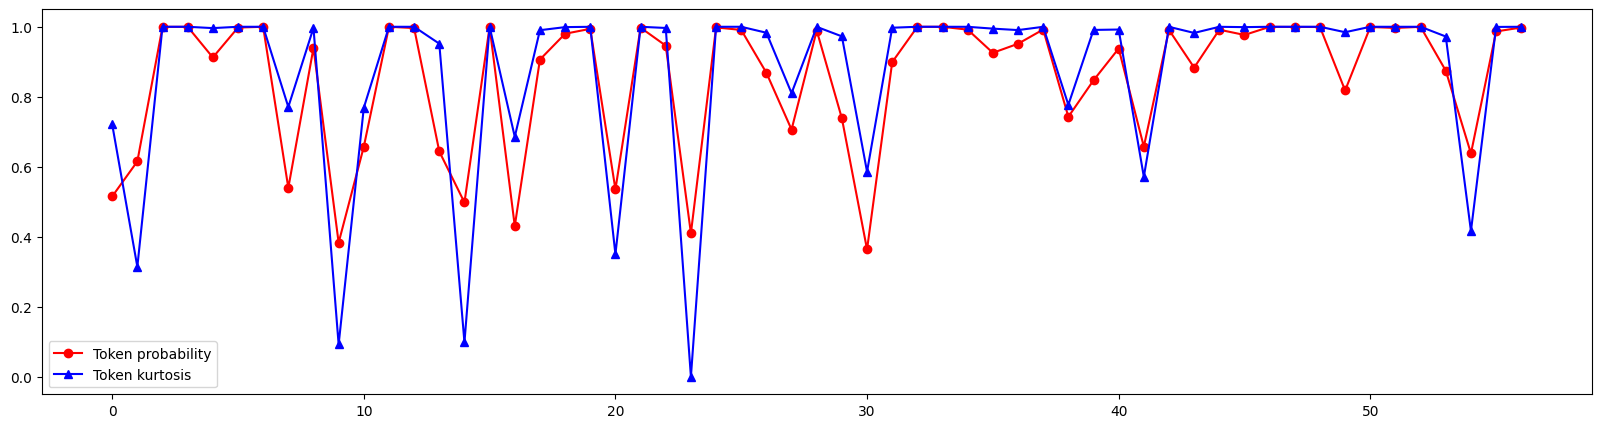

In [7]:
for i in range(5):
    print(f"--------------- Sample {i} ---------------")
    input_text = f"translate English to German: {ds_de_en['train'][i]['translation']['en']}"
    true_translation = ds_de_en['train'][i]['translation']['de']
    predicted_translation, token_probs, token_kurtosis = generate_output_with_probs(model=t5_model_small, tokenizer=t5_tokenizer_small, example=input_text)

    # tokenize 
    true_tokens = t5_tokenizer_small.tokenize(true_translation)
    predicted_tokens = t5_tokenizer_small.tokenize(predicted_translation)

    # uncertainty quantification using kurtosis 
    token_kurtosis = token_kurtosis.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_token_kurtosis = scaler.fit_transform(token_kurtosis).flatten() 

    # already available metrics
    bleu   = calculate_bleu([true_tokens], predicted_tokens)                                            # 1. BLEU
    meteor = meteor_score([true_tokens], predicted_tokens)                                              # 2. METEOR (# jhpark: verified that this is a correct way to use this.)
    rouge  = calculate_rouge(true_translation, predicted_translation)                                   # 3. ROUGE
    bert = bertscore.compute(predictions=[predicted_translation], references=[true_translation], model_type='distilbert-base-multilingual-cased') # 4. BERTscore.

    # print results
    print("[Sentences]")
    print("   Input:", input_text)
    print("   True Translation:", true_translation)
    print("   Predicted Translation:", predicted_translation)

    print("\n[Scores]")
    print("   BLEU score:", bleu)
    print("   METEOR score:", meteor)
    print("   ROUGE score:", rouge)
    print("   BERT score:", bert)

    print("\n[Uncertainty Quantification]")
    # print(f"   Token length: {len(token_probs)}")
    print(f"   Top 1 token probabilities (Geometric mean): {np.round(gmean(token_probs), 3)}")
    print(f"   Top 1 token probabilities: {np.round(token_probs, 3)}")
    print(f"   Scaled kurtosis: {np.round(scaled_token_kurtosis, 3)}")
    # print(f"   Top 1 token probabilities (Harmonic mean): {np.round(hmean(token_probs), 3)}")

    # visualization for token probability and kurtosis
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.plot(np.arange(0, len(token_probs)), token_probs, label='Token probability', c='red', marker='o')
    ax.plot(np.arange(0, len(token_probs)), scaled_token_kurtosis, label='Token kurtosis', c='blue', marker='^')
    ax.legend()
    plt.show()


### 2. Generate translations (English to French)

--------------- Sample 0 ---------------


7it [00:00, 1325.57it/s]


[Sentences]
   Input: translate English to French: Resumption of the session
   True Translation: Reprise de la session
   Predicted Translation: Reprise de la session

[Scores]
   BLEU score: 1.0
   METEOR score: 0.996
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [0.9999998211860657], 'recall': [0.9999998211860657], 'f1': [0.9999998211860657], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilities (Geometric mean): 0.957
   Top 1 token probabilities: [0.779 1.    0.998 0.996 0.998 0.996]
   Scaled kurtosis: [0. 1. 1. 1. 1. 1.]


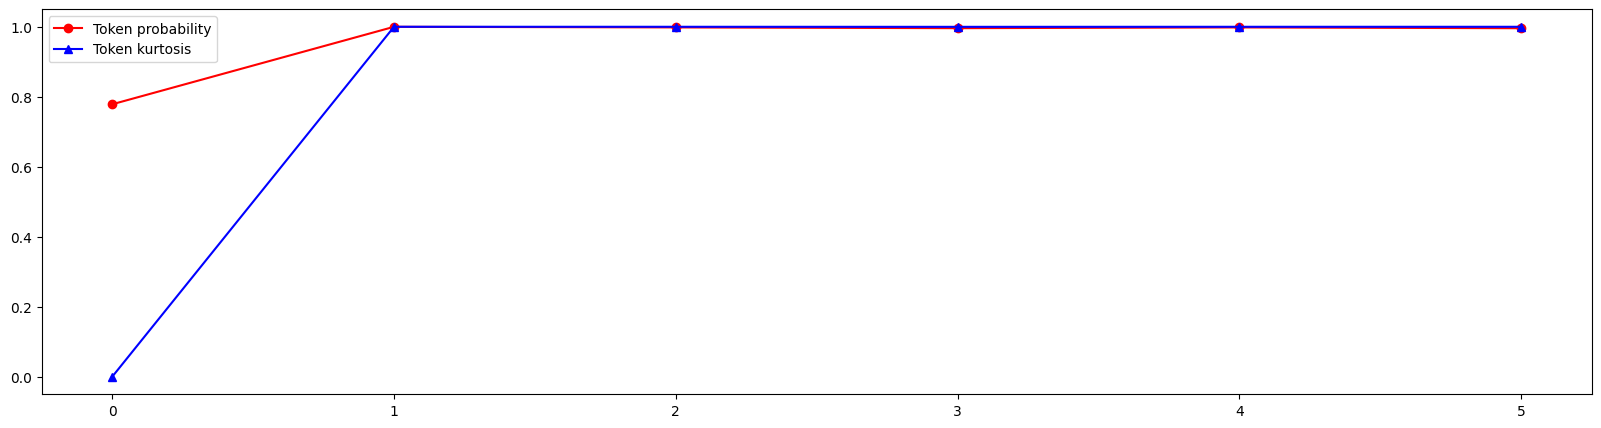

--------------- Sample 1 ---------------


50it [00:00, 1462.37it/s]

[Sentences]
   Input: translate English to French: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
   True Translation: Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances.
   Predicted Translation: Je déclare reprise la session du Parlement européen interrompue le vendredi 17 décembre 1999 et je voudrais vous souhaiter une nouvelle année heureuse dans l'espoir que vous avez eu une agréable période festive.

[Scores]
   BLEU score: 0.40696592157185546
   METEOR score: 0.575153374233129
   ROUGE score: {'rouge1': Score(precision=0.55, recall=0.5945945945945946, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.4358974358974359, recall=0.4722222222222222, fmeasure=0.453333333333333

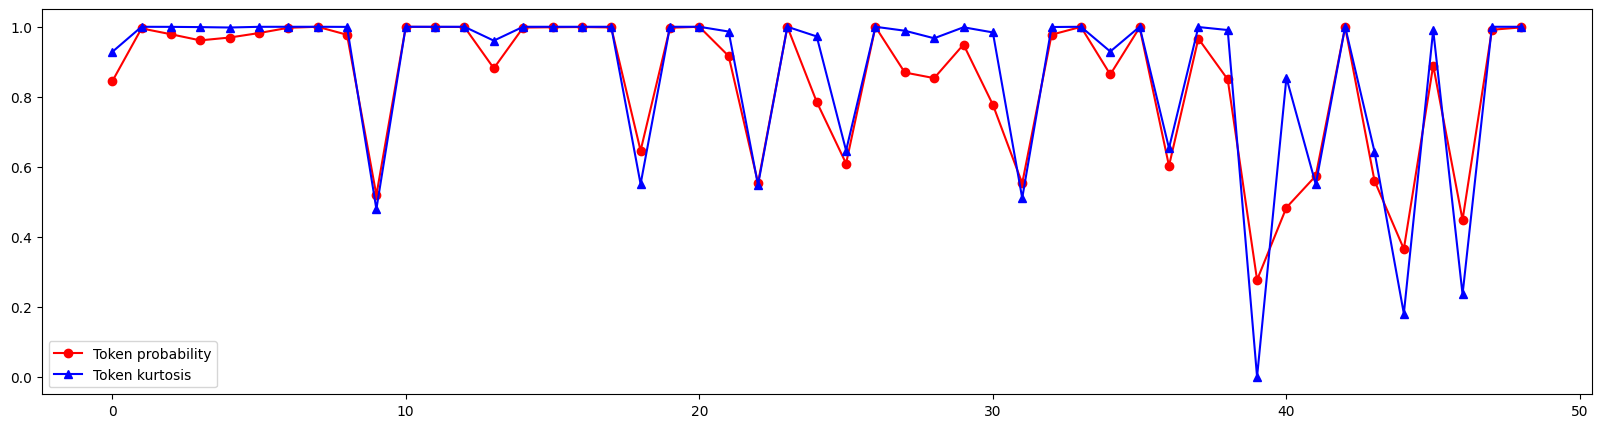

--------------- Sample 2 ---------------


64it [00:00, 1453.98it/s]

[Sentences]
   Input: translate English to French: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
   True Translation: Comme vous avez pu le constater, le grand "bogue de l'an 2000" ne s'est pas produit. En revanche, les citoyens d'un certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles.
   Predicted Translation: Bien que, comme vous l'avez vu, le bogue du millénaire n'ait pas eu lieu, les populations d'un certain nombre de pays ont encore subi une série de catastrophes naturelles qui étaient vraiment épouvantables.

[Scores]
   BLEU score: 0.24633861210301242
   METEOR score: 0.5377632542268387
   ROUGE score: {'rouge1': Score(precision=0.5526315789473685, recall=0.525, fmeasure=0.5384615384615385), 'rouge2': Score(precision=0.24324324324324326, recall=0.23076923076923078, fmeasure=0.2368421052

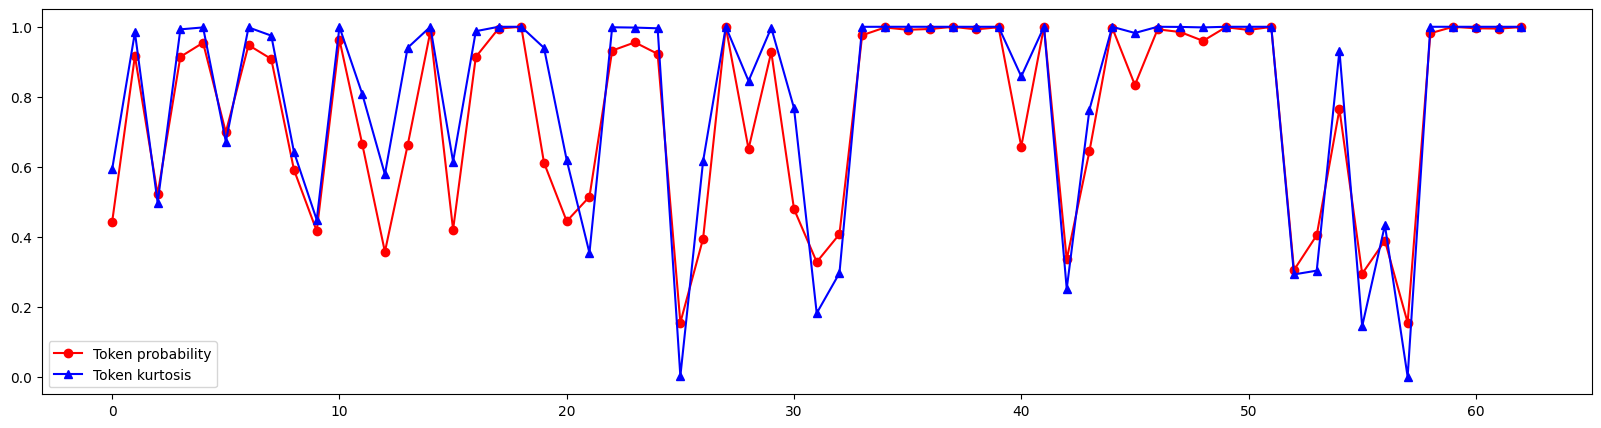

--------------- Sample 3 ---------------


27it [00:00, 630.33it/s]

[Sentences]
   Input: translate English to French: You have requested a debate on this subject in the course of the next few days, during this part-session.
   True Translation: Vous avez souhaité un débat à ce sujet dans les prochains jours, au cours de cette période de session.
   Predicted Translation: Vous avez demandé un débat sur ce sujet au cours des prochains jours, durant cette période de session.

[Scores]
   BLEU score: 0.4095272735780044
   METEOR score: 0.8076739237695818
   ROUGE score: {'rouge1': Score(precision=0.8, recall=0.8, fmeasure=0.8000000000000002), 'rouge2': Score(precision=0.5263157894736842, recall=0.5263157894736842, fmeasure=0.5263157894736842), 'rougeL': Score(precision=0.7, recall=0.7, fmeasure=0.7)}
   BERT score: {'precision': [0.9685285091400146], 'recall': [0.9584172964096069], 'f1': [0.9634463787078857], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilit

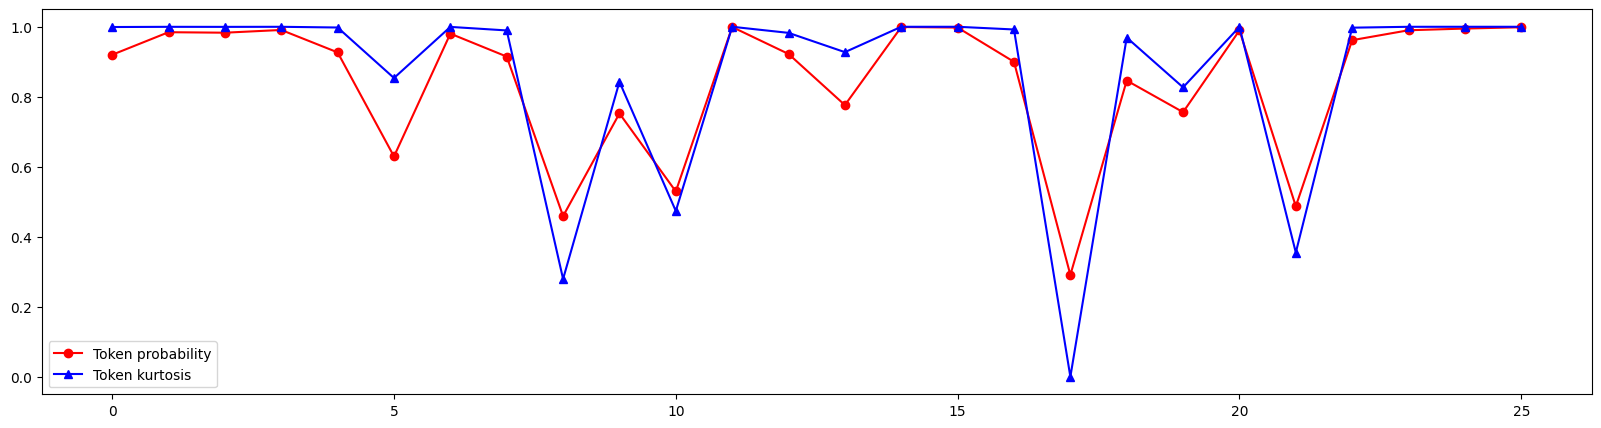

--------------- Sample 4 ---------------


59it [00:00, 1460.07it/s]

[Sentences]
   Input: translate English to French: In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.
   True Translation: En attendant, je souhaiterais, comme un certain nombre de collègues me l'ont demandé, que nous observions une minute de silence pour toutes les victimes, des tempêtes notamment, dans les différents pays de l'Union européenne qui ont été touchés.
   Predicted Translation: Entre-temps, je voudrais observer une minute de silence, comme l'ont demandé plusieurs députés, au nom de toutes les victimes concernées, en particulier celles des terribles tempêtes, dans les différents pays de l'Union européenne.

[Scores]
   BLEU score: 0.37246522718389913
   METEOR score: 0.6119151261612678
   ROUGE score: {'rouge1': Score(precision=0.6666666666666666, recall=0.6222222222222222, fmeasure=0.643678160

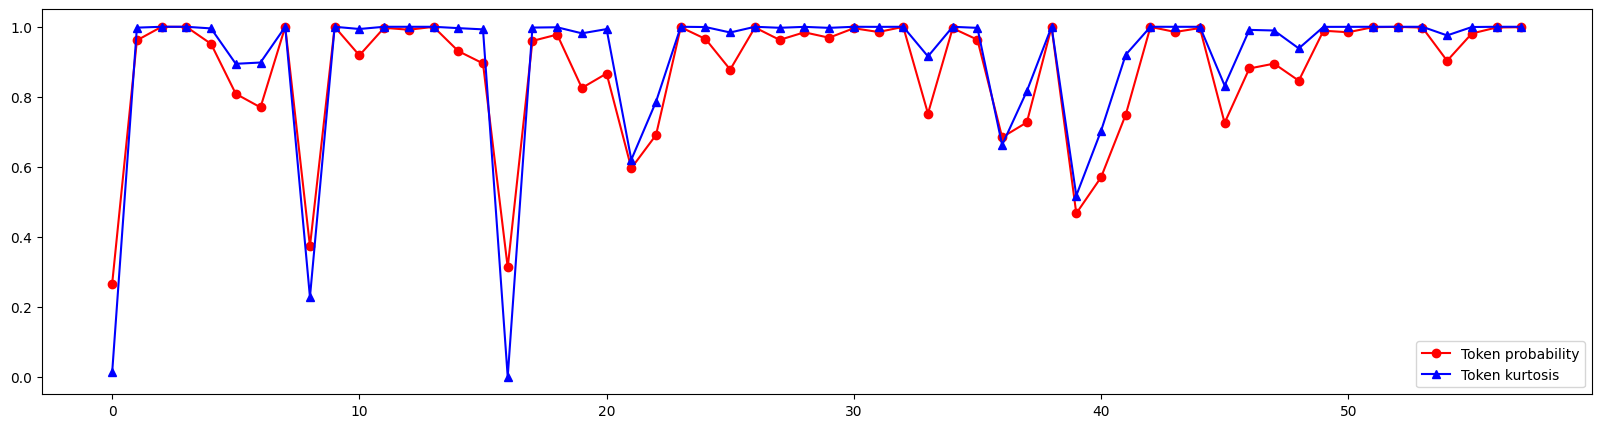

In [8]:
for i in range(5):
    print(f"--------------- Sample {i} ---------------")
    input_text = f"translate English to French: {ds_fr_en['train'][i]['translation']['en']}"
    true_translation = ds_fr_en['train'][i]['translation']['fr']
    predicted_translation, token_probs, token_kurtosis = generate_output_with_probs(model=t5_model_small, tokenizer=t5_tokenizer_small, example=input_text)

    # tokenize 
    true_tokens = t5_tokenizer_small.tokenize(true_translation)
    predicted_tokens = t5_tokenizer_small.tokenize(predicted_translation)

    # uncertainty quantification using kurtosis 
    token_kurtosis = token_kurtosis.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_token_kurtosis = scaler.fit_transform(token_kurtosis).flatten() 

    # already available metrics
    bleu   = calculate_bleu([true_tokens], predicted_tokens)                                            # 1. BLEU
    meteor = meteor_score([true_tokens], predicted_tokens)                                              # 2. METEOR (# jhpark: verified that this is a correct way to use this.)
    rouge  = calculate_rouge(true_translation, predicted_translation)                                   # 3. ROUGE
    bert = bertscore.compute(predictions=[predicted_translation], references=[true_translation], model_type='distilbert-base-multilingual-cased') # 4. BERTscore.

    # print results
    print("[Sentences]")
    print("   Input:", input_text)
    print("   True Translation:", true_translation)
    print("   Predicted Translation:", predicted_translation)

    print("\n[Scores]")
    print("   BLEU score:", bleu)
    print("   METEOR score:", meteor)
    print("   ROUGE score:", rouge)
    print("   BERT score:", bert)

    print("\n[Uncertainty Quantification]")
    # print(f"   Token length: {len(token_probs)}")
    print(f"   Top 1 token probabilities (Geometric mean): {np.round(gmean(token_probs), 3)}")
    print(f"   Top 1 token probabilities: {np.round(token_probs, 3)}")
    print(f"   Scaled kurtosis: {np.round(scaled_token_kurtosis, 3)}")
    # print(f"   Top 1 token probabilities (Harmonic mean): {np.round(hmean(token_probs), 3)}")

    # visualization for token probability and kurtosis
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.plot(np.arange(0, len(token_probs)), token_probs, label='Token probability', c='red', marker='o')
    ax.plot(np.arange(0, len(token_probs)), scaled_token_kurtosis, label='Token kurtosis', c='blue', marker='^')
    ax.legend()
    plt.show()


### 3. Generate translations (English to Romanian)

--------------- Sample 0 ---------------


16it [00:00, 1526.45it/s]

[Sentences]
   Input: translate English to Romanian: Membership of Parliament: see Minutes
   True Translation: Componenţa Parlamentului: a se vedea procesul-verbal
   Predicted Translation: Componenţa Parlamentului: a se vedea procesul-verbal

[Scores]
   BLEU score: 1.0
   METEOR score: 0.9998177842565598
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [1.0], 'recall': [1.0], 'f1': [1.0], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilities (Geometric mean): 0.988
   Top 1 token probabilities: [1.    1.    0.974 0.999 1.    0.998 0.862 1.    1.    1.    1.    1.
 1.    1.    1.   ]
   Scaled kurtosis: [1.    1.    0.973 1.    1.    1.    0.    1.    1.    1.    1.    1.
 1.    1.    1.   ]


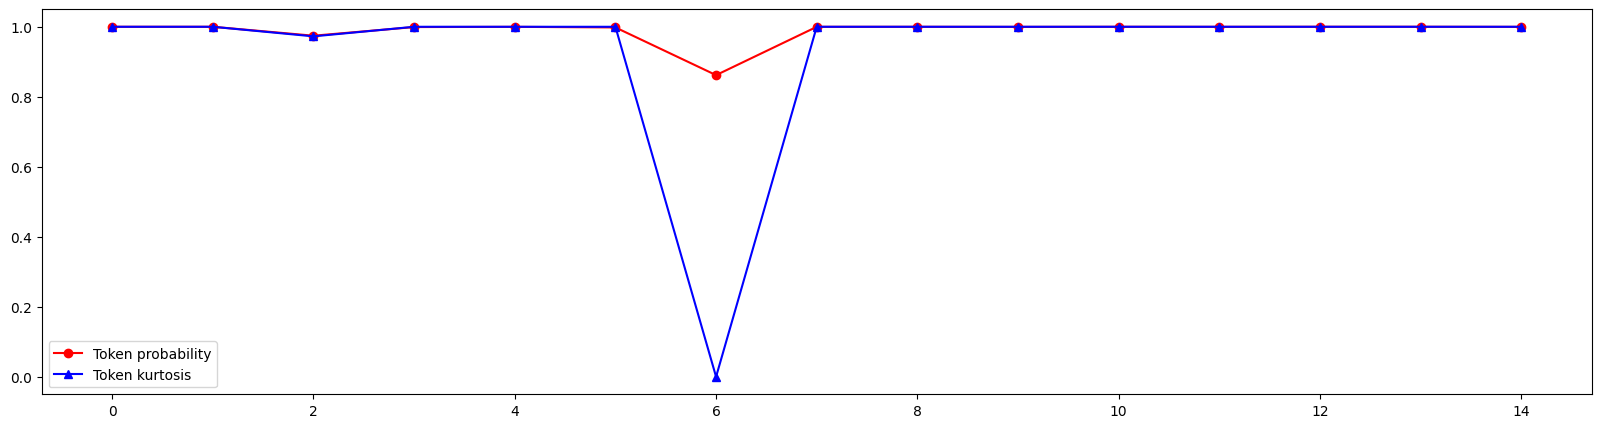

--------------- Sample 1 ---------------


25it [00:00, 1414.17it/s]

[Sentences]
   Input: translate English to Romanian: Approval of Minutes of previous sitting: see Minutes
   True Translation: Aprobarea procesului-verbal al şedinţei precedente: a se vedea procesul-verbal
   Predicted Translation: Aprobarea procesului-verbal al şedinţei precedente: a se vedea procesul-verbal

[Scores]
   BLEU score: 1.0
   METEOR score: 0.999958905235473
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [1.0000001192092896], 'recall': [1.0000001192092896], 'f1': [1.0000001192092896], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilities (Geometric mean): 0.994
   Top 1 token probabilities: [0.999 1.    0.998 0.999 1.    1.    1.    1.    0.999 0.968 1.    1.
 1.    1.    0.999 0.907 1.    1.    1.    1.  

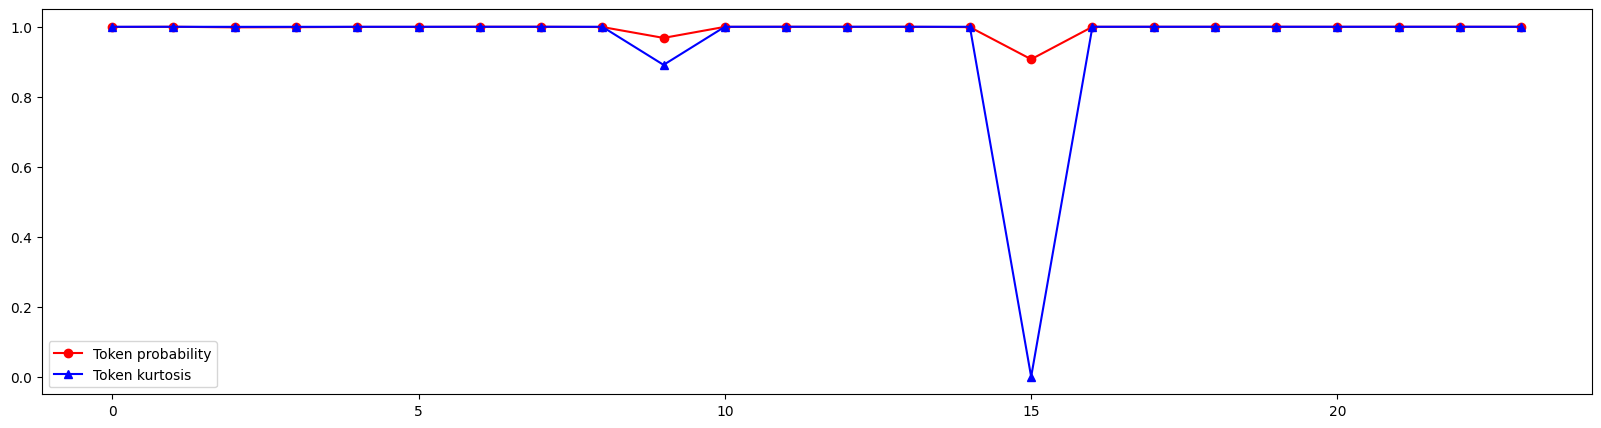

--------------- Sample 2 ---------------


16it [00:00, 1434.23it/s]

[Sentences]
   Input: translate English to Romanian: Membership of Parliament: see Minutes
   True Translation: Componenţa Parlamentului: a se vedea procesul-verbal
   Predicted Translation: Componenţa Parlamentului: a se vedea procesul-verbal

[Scores]
   BLEU score: 1.0
   METEOR score: 0.9998177842565598
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [1.0], 'recall': [1.0], 'f1': [1.0], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilities (Geometric mean): 0.988
   Top 1 token probabilities: [1.    1.    0.974 0.999 1.    0.998 0.862 1.    1.    1.    1.    1.
 1.    1.    1.   ]
   Scaled kurtosis: [1.    1.    0.973 1.    1.    1.    0.    1.    1.    1.    1.    1.
 1.    1.    1.   ]


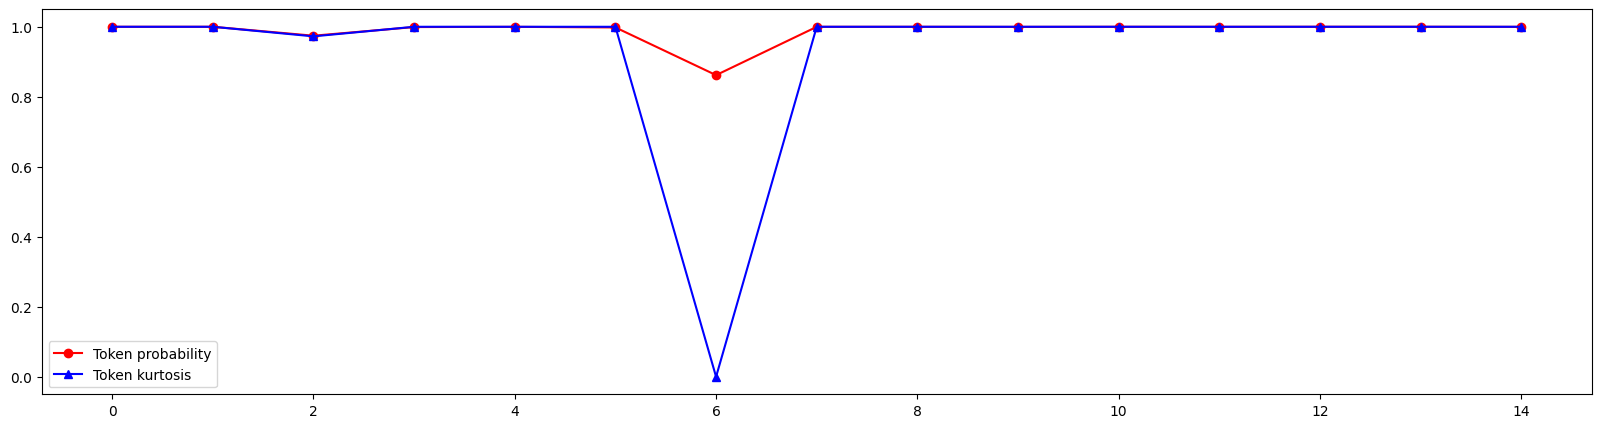

--------------- Sample 3 ---------------


18it [00:00, 1465.34it/s]

[Sentences]
   Input: translate English to Romanian: Verification of credentials: see Minutes
   True Translation: Verificarea prerogativelor: a se vedea procesul-verbal
   Predicted Translation: Verificarea prerogativelor: a se vedea procesul-verbal

[Scores]
   BLEU score: 1.0
   METEOR score: 0.9998779296875
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [0.9999998807907104], 'recall': [0.9999998807907104], 'f1': [0.9999998807907104], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilities (Geometric mean): 0.959
   Top 1 token probabilities: [0.954 0.998 0.999 0.994 1.    1.    0.999 0.999 0.525 1.    1.    0.999
 1.    1.    1.    1.    1.   ]
   Scaled kurtosis: [0.993 1.    1.    1.    1.    1.    1.    1.    0.   

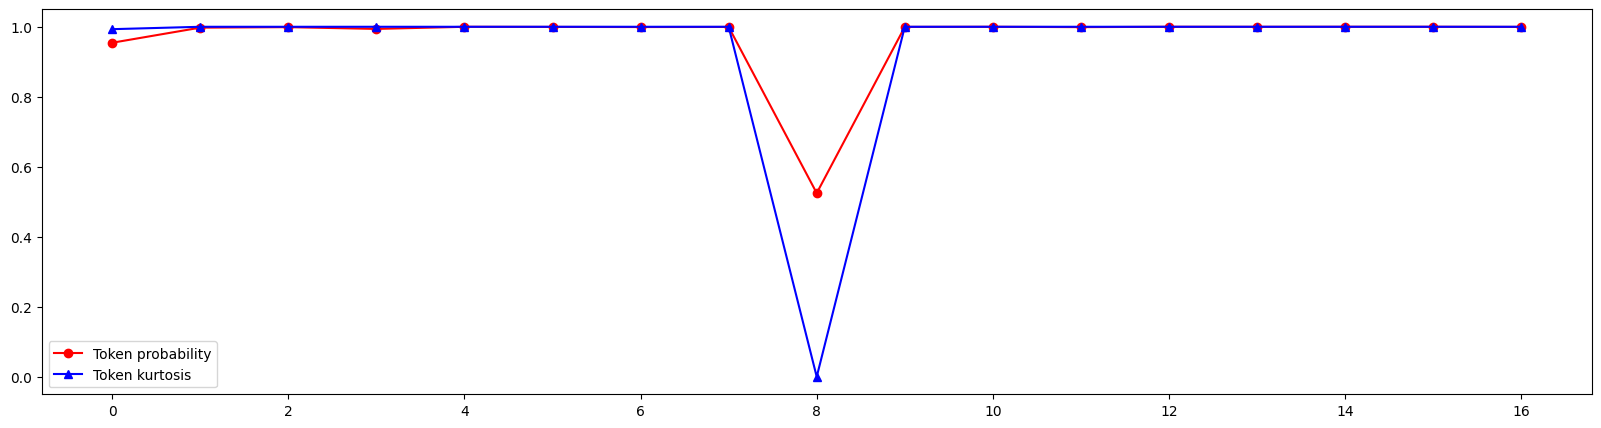

--------------- Sample 4 ---------------


15it [00:00, 1519.42it/s]

[Sentences]
   Input: translate English to Romanian: Documents received: see Minutes
   True Translation: Depunere de documente: a se vedea procesul-verbal
   Predicted Translation: Depunerea documentelor: a se vedea procesul-verbal

[Scores]
   BLEU score: 0.540856266901231
   METEOR score: 0.6935305574564405
   ROUGE score: {'rouge1': Score(precision=0.7142857142857143, recall=0.625, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.6666666666666666, recall=0.5714285714285714, fmeasure=0.6153846153846153), 'rougeL': Score(precision=0.7142857142857143, recall=0.625, fmeasure=0.6666666666666666)}
   BERT score: {'precision': [0.9616718888282776], 'recall': [0.9546576738357544], 'f1': [0.9581519365310669], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilities (Geometric mean): 0.999
   Top 1 token probabilities: [0.999 0.999 1.    1.    0.999 0.992 1.    1.    1.    1.    1.    1.
 

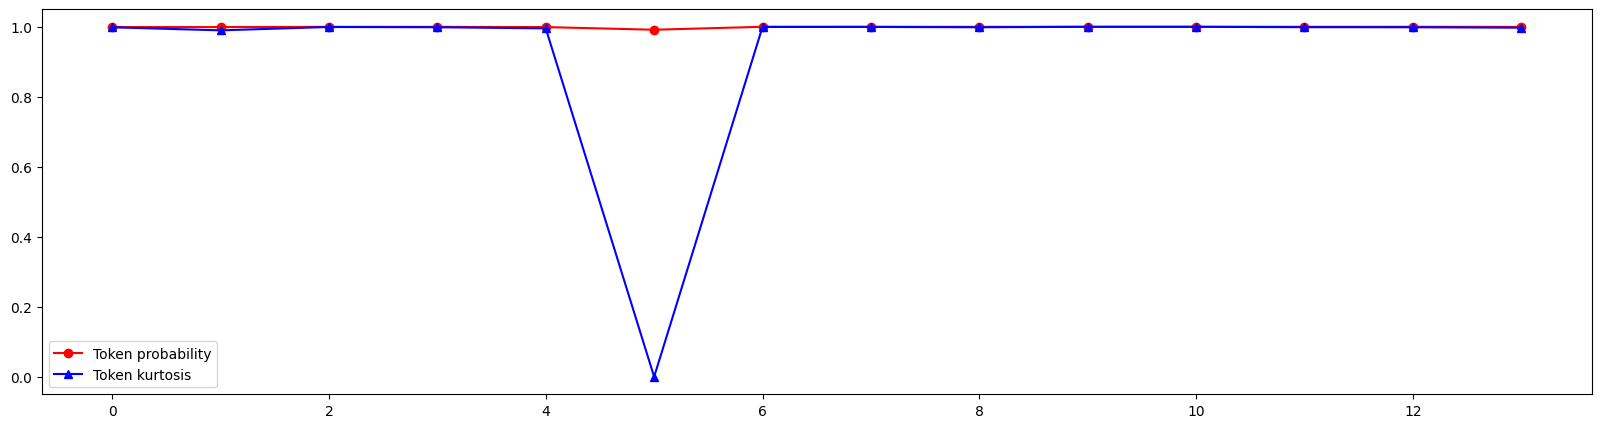

In [9]:
for i in range(5):
    print(f"--------------- Sample {i} ---------------")
    input_text = f"translate English to Romanian: {ds_ro_en['train'][i]['translation']['en']}"
    true_translation = ds_ro_en['train'][i]['translation']['ro']
    predicted_translation, token_probs, token_kurtosis = generate_output_with_probs(model=t5_model_small, tokenizer=t5_tokenizer_small, example=input_text)

    # tokenize 
    true_tokens = t5_tokenizer_small.tokenize(true_translation)
    predicted_tokens = t5_tokenizer_small.tokenize(predicted_translation)

    # uncertainty quantification using kurtosis 
    token_kurtosis = token_kurtosis.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_token_kurtosis = scaler.fit_transform(token_kurtosis).flatten() 

    # already available metrics
    bleu   = calculate_bleu([true_tokens], predicted_tokens)                                            # 1. BLEU
    meteor = meteor_score([true_tokens], predicted_tokens)                                              # 2. METEOR (# jhpark: verified that this is a correct way to use this.)
    rouge  = calculate_rouge(true_translation, predicted_translation)                                   # 3. ROUGE
    bert = bertscore.compute(predictions=[predicted_translation], references=[true_translation], model_type='distilbert-base-multilingual-cased') # 4. BERTscore.

    # print results
    print("[Sentences]")
    print("   Input:", input_text)
    print("   True Translation:", true_translation)
    print("   Predicted Translation:", predicted_translation)

    print("\n[Scores]")
    print("   BLEU score:", bleu)
    print("   METEOR score:", meteor)
    print("   ROUGE score:", rouge)
    print("   BERT score:", bert)

    print("\n[Uncertainty Quantification]")
    # print(f"   Token length: {len(token_probs)}")
    print(f"   Top 1 token probabilities (Geometric mean): {np.round(gmean(token_probs), 3)}")
    print(f"   Top 1 token probabilities: {np.round(token_probs, 3)}")
    print(f"   Scaled kurtosis: {np.round(scaled_token_kurtosis, 3)}")
    # print(f"   Top 1 token probabilities (Harmonic mean): {np.round(hmean(token_probs), 3)}")

    # visualization for token probability and kurtosis
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.plot(np.arange(0, len(token_probs)), token_probs, label='Token probability', c='red', marker='o')
    ax.plot(np.arange(0, len(token_probs)), scaled_token_kurtosis, label='Token kurtosis', c='blue', marker='^')
    ax.legend()
    plt.show()


The following metrics cannot be used because we only have one-to-one translations.

1. CIDEr: Consensus-based Image Description Evaluation
2. SPICE: Semantic Propositional Image Caption Evaluation